In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from io import StringIO
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

%matplotlib inline

#### Model Selection
Before deploying a model the first step is to select a model that can perform regression form rental prices based on the data in the database

First extract the data from the database

In [168]:
r = requests.get(
    url=f"http://localhost:8000/ml/train-data", headers={"x-api-key": "admin_api_key"}
)

df = pd.read_json(StringIO(r.text))
df["district_name"] = df["district_name"].astype("category")

In [169]:
df.head()

,district_name,area,rooms,price
0,Altstadt,90.0,2.0,1800.0
1,Angermund,186.0,4.0,2086.5
2,Angermund,105.0,4.0,1200.0
3,Benrath,108.0,3.0,1644.0
4,Benrath,75.0,3.0,1145.0


In [170]:
df.describe()

,area,rooms,price
count,6356.000000,6356.000000,6356.000000
mean,76.219308,2.477108,1120.885857
std,36.349587,0.937665,803.226157
min,10.000000,1.000000,180.000000
25%,54.000000,2.000000,680.000000
50%,70.000000,2.000000,900.000000
75%,90.000000,3.000000,1340.000000
max,460.000000,8.000000,11040.000000


array([[<Axes: xlabel='area', ylabel='area'>,
        <Axes: xlabel='rooms', ylabel='area'>,
        <Axes: xlabel='price', ylabel='area'>],
       [<Axes: xlabel='area', ylabel='rooms'>,
        <Axes: xlabel='rooms', ylabel='rooms'>,
        <Axes: xlabel='price', ylabel='rooms'>],
       [<Axes: xlabel='area', ylabel='price'>,
        <Axes: xlabel='rooms', ylabel='price'>,
        <Axes: xlabel='price', ylabel='price'>]], dtype=object)

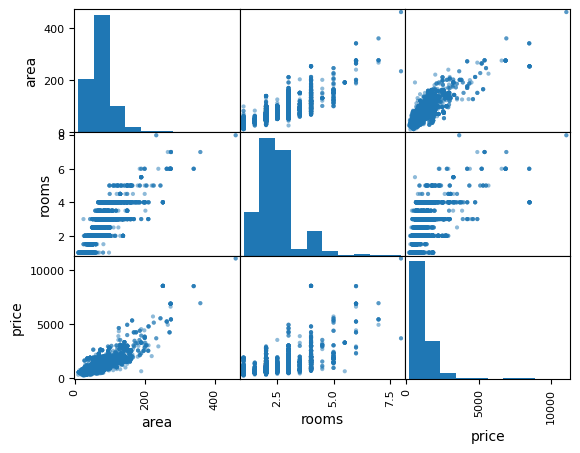

In [171]:
pd.plotting.scatter_matrix(df)

Looks like all the variables have an influence on the price, which seems reasonable. 
Before training the model we need to extract feature- and target variables

In [172]:
X_raw = df.drop("price", axis=1)
y = df.price

Since "district_name" is categorical we need to introduce dummy variables. 
This is done by the DictVectorizer

In [173]:
transformer = DictVectorizer()

X = transformer.fit_transform(X_raw.to_dict("records"))

Now split the data in training and test data

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now we want to test some models on the data. So lets create a function that takes a model, trains it on the training data and does some model evaluation.

In [184]:
from sklearn.metrics import root_mean_squared_error


def evaluate_model(model):
    model.fit(X_train, y_train)
    # Training score
    train_score = model.score(X_train, y_train)
    print(f"Score on training data is {train_score:.4f}")
    # Test score
    test_score = model.score(X_test, y_test)
    print(f"Score on test data is {test_score:.4f}")
    # Crossvalidation score
    scores = cross_val_score(model, X, y, cv=3)
    print(f"CV Score: {scores.mean():.4f} ± {scores.std():.4f}")
    # MSE on test data set
    y_pred = model.predict(X_test)
    mse = root_mean_squared_error(y_pred, y_test)
    print(f"The MSE is {mse:.4f}")
    # plot the residuals
    res = y_test - y_pred
    res.hist()
    plt.title("Histogram of residuals")
    plt.show()

## Linear Model

Score on training data is 0.7879
Score on test data is 0.7828
CV Score: 0.7705 ± 0.0341
The MSE is 375.7161


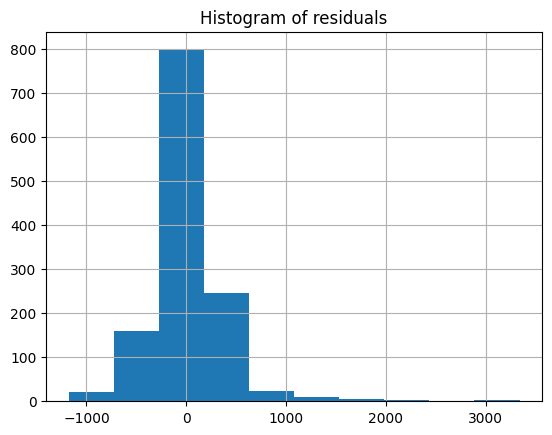

In [185]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
evaluate_model(linear_model)

Score and varaince are looking good

## Lasso Regression

Score on training data is 0.7878
Score on test data is 0.7832
CV Score: 0.7712 ± 0.0338
The MSE is 375.3513


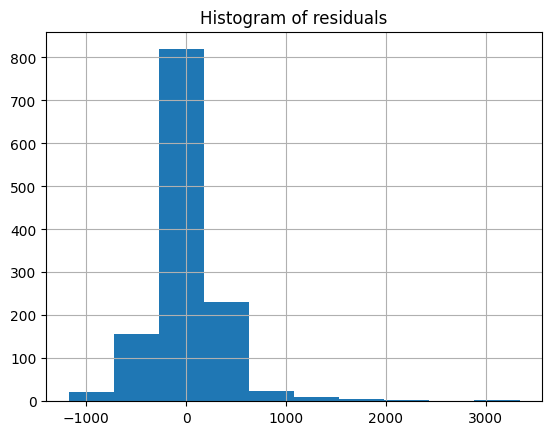

In [186]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1)
evaluate_model(lasso_model)

Looks like the values from the linear model

## Random Forrest

Score on training data is 0.9873
Score on test data is 0.9512
CV Score: 0.9046 ± 0.0369
The MSE is 178.1699


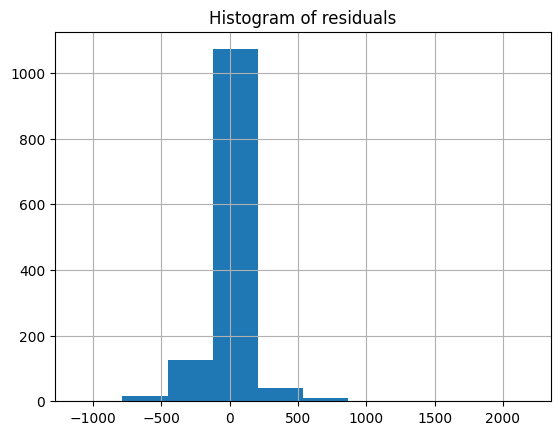

In [187]:
from sklearn.ensemble import RandomForestRegressor

forrest = RandomForestRegressor()
evaluate_model(forrest)

The random forrest seems to perform better than the linear models. This looks like a pretty solid performance

## Gradient Boosting Regressor

Score on training data is 0.9414
Score on test data is 0.9414
CV Score: 0.8903 ± 0.0402
The MSE is 218.8955


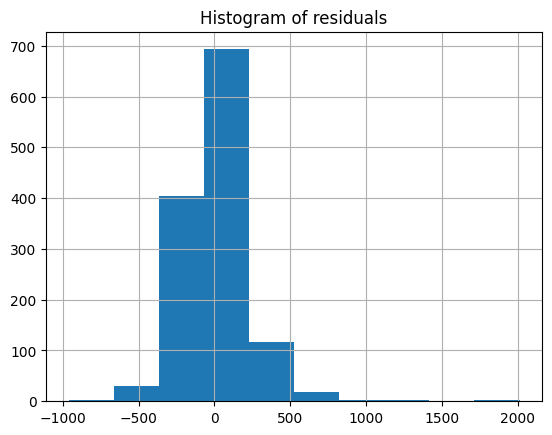

In [179]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(learning_rate=0.4)
evaluate_model(gradient_boosting)

## SVC

Score on training data is 0.2375
Score on test data is 0.2375
CV Score: 0.2295 ± 0.0263
The MSE is 698.5764


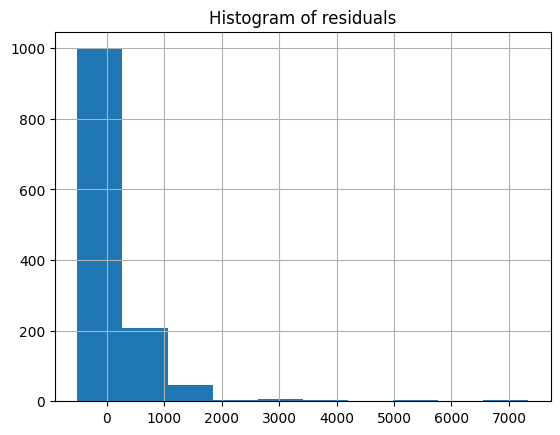

In [180]:
from sklearn.svm import SVR

svr = SVR()
evaluate_model(svr)

SVM performs very poor

I descided to go with the Random Forrest Regressor, since it seems to have a pretty good performance.
This is the final model:

In [181]:
from sklearn.pipeline import Pipeline

final_model = Pipeline(
    [("transformer", DictVectorizer()), ("tree", RandomForestRegressor())]
)

final_model.fit(X_raw.to_dict("records"), y)

Pipeline(steps=[('transformer', DictVectorizer()),
                ('tree', RandomForestRegressor())])

In [182]:
final_model.score(X_raw.to_dict("records"), y)

0.987909681050502

In [201]:
import numpy as np

forest = final_model["tree"]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [203]:
forest_importances = pd.Series(
    importances, index=final_model["transformer"].feature_names_
)

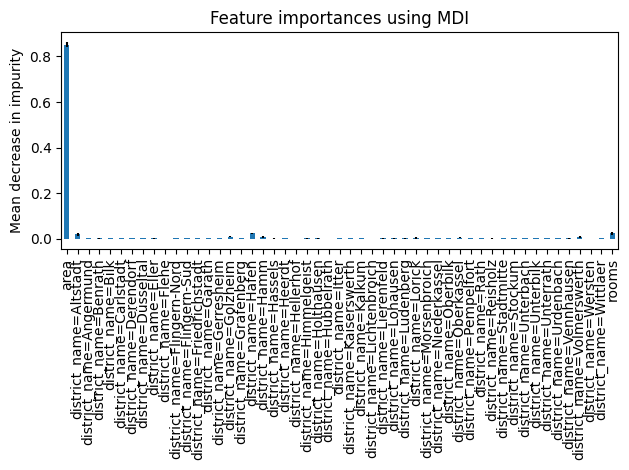

In [204]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

makes a lot of sense that the area has a huge impact on the price since the price is usually calculated from the price per sqm